## Libraries

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
import re

## Read CSV

In [80]:
nquestions=50_000
df = pd.read_csv('Train.csv', nrows=nquestions)
df

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents
...,...,...,...,...
49995,49996,warning: iPad only apps should not include an ...,<p>I am submitting an app and i am getting an ...,ios armv6
49996,49997,Artefact behind master view controller in spli...,<p>I have a problem on iOS 5.1 with split view...,ios ipad ios5.1
49997,49998,Sending an UIImage to multiplayer through Game...,<p>I have a UIImage which comes from CGContext...,iphone iphone-sdk-4.0 ios5 xcode4.2 game-center
49998,49999,Setting Connection attributes for DataDefModel...,<p>How should I modify the below code so that ...,c# .net sql crystal-reports sql-server-express


## Exploratory Data Analysis

In [81]:
def tags_iter():
    return (set(tags.split()) for tags in df['Tags'])

In [82]:
tags_count = {}
for tags in tags_iter():
    for tag in tags:
        tags_count[tag] = tags_count.get(tag, 0) + 1

In [83]:
len(tags_count)

13892

Text(0.5, 0, 'Number of tags')

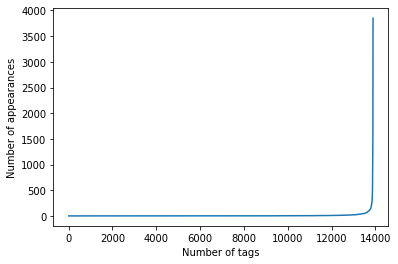

In [84]:
plt.plot(sorted(tags_count.values()))
plt.ylabel('Number of appearances')
plt.xlabel('Number of tags')

In [85]:
# Most common tags
n_top = 500
tags_top_sorted = sorted(tags_count.keys(), key=lambda x: -tags_count[x])[:n_top]
tags_top = set(tags_top_sorted)
tags_top_sorted[:10]

['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'iphone',
 'python',
 'asp.net']

In [86]:
count = 0
for tags in tags_iter():
    for tag in tags:
        if tag in tags_top:
            count+=1
            break
print(f"Contains {count} questions out of {nquestions}")
print(f"Question coverage: {100 * count / nquestions}%")

Contains 44844 questions out of 50000
Question coverage: 89.688%


## Build $X_{train}$ and $Y_{train}$

In [89]:
# Select rows with at least one tag in top
mask = df['Tags'].map(
    lambda field: any(
        # Look if tag is contained in the top
        tag in tags_top \
            for tag in field.split()
    )
)
df_train = df[mask]

### Getting $Y_{train}$

In [91]:
from sklearn.preprocessing import MultiLabelBinarizer

In [108]:
mlb = MultiLabelBinarizer()
mlb.fit([tags_top])

In [118]:
# Now mlb can transform list of tags to multilabel format (1,0,...,0,1,0)
mlb.transform([
    ['c#', 'algorithm'],
    ['c++', 'java', 'javascript'],
    ['python']
])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [132]:
# Convert tags to binarized output
Y_train = df_train['Tags'].map(lambda s: s.split())

# Ignore unknown class warning since all tag sets contain at least one tag in tag_top
Y_train = mlb.transform(Y_train)

# Verify all entries contain at least one tag
print(f"All good: {all(np.any(Y_train, axis=1))}")

All good: True


### Getting $X_{train}$

In [230]:
def clean_text(text):
    """
    Normalize format of words, ready to be splitted
    """
    # lowercase
    text = text.lower()
    text = text.strip()
    # Abbreviations
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    # Delete HTML tags
    text = re.sub("<(\"[^\"]*\"|'[^']*'|[^'\">])*>", '', text)
    # Delete period, comma, quotation, interrogation, admiration
    text = re.sub(r'[\.,\'\(\)\?!]', '', text)
    # Replace slash
    text = re.sub(r'/', ' ', text)
    # Replace line breaks (and spaces)
    text = re.sub(r'\n+', ' ', text)
    
    return text

In [236]:
def get_words_bag(words):
    bag = {}
    for wd in words:
        ### Ignore empty str
        if wd == '': continue
        bag[wd] = bag.get(wd, 0) + 1
    return bag

In [232]:
## Append body and title together
X_train = (df_train['Body'] + ' ' + df_train['Title'])
# Clean text
X_train = X_train.map(clean_text)
# Split into words
X_train = X_train.map(str.split)

X_train = X_train.map(get_words_bag)

In [250]:
X_train

0        {'i': 2, 'would': 1, 'like': 1, 'to': 4, 'chec...
1        {'in': 1, 'my': 1, 'favorite': 1, 'editor': 1,...
2        {'i': 5, 'am': 2, 'import': 2, 'matlab': 5, 'f...
3        {'this': 4, 'is': 3, 'probably': 1, 'very': 1,...
4        {'function': 2, 'modify': 4, '{': 1, '$mcontac...
                               ...                        
49995    {'i': 2, 'am': 2, 'submitting': 1, 'an': 4, 'a...
49996    {'i': 6, 'have': 1, 'a': 4, 'problem': 2, 'on'...
49997    {'i': 2, 'have': 1, 'a': 1, 'uiimage': 2, 'whi...
49998    {'how': 1, 'should': 1, 'i': 2, 'modify': 1, '...
49999    {'let': 1, 'us': 1, 'say': 1, 'that': 2, 'i': ...
Length: 44844, dtype: object

In [222]:
### TODO:
# Get tf-idf of word bags and train

'how to check if an uploaded file is an image without mime type'